In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession, functions as f
from pyspark.sql.types import *
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local").setAppName("ts")
sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession.builder.appName('SentimentTwitter').getOrCreate()
from pyspark.sql import SQLContext
import re

In [2]:
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [3]:
def process_file(file_name):
    rdd = sc.wholeTextFiles(file_name)\
    .map(lambda x: re.sub(r'(?!(([^"]*"){2})*[^"]*$),', ' ', x[1].replace("\r\n", ",").replace(",,", ",")).split(","))\
    .flatMap(lambda x: [x[k:k+8] for k in range(0, len(x), 8)])
    return rdd

In [4]:
def clean_data(old_df, col_name):
    new_df = old_df.select(f.regexp_replace(f.col("tweet_text"), \
                                            "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", "").alias("tweet_text"))
    new_df = new_df.select(f.regexp_replace(f.col('tweet_text'), \
                                           '@\w+', '').alias('tweet_text')) # Remove @
    new_df = new_df.select(f.regexp_replace(f.col("tweet_text"), \
                                           '#+', '').alias('tweet_text')) # Remove #
    ew_df = new_df.select(f.regexp_replace(f.col('tweet_text'), \
                                           '"', '').alias("tweet_text")) 
    new_df = new_df.select(f.regexp_replace(f.col("tweet_text"), \
                                           'https?:\/\/\S+', '').alias("tweet_text"))
    new_df = new_df.select(f.regexp_replace(f.col('tweet_text'), \
                                           '"+', '').alias('tweet_text'))
    new_df = new_df.select(f.regexp_replace(f.col('tweet_text'), \
                                           '\n+', '').alias('tweet_text'))
    new_df = new_df.select(f.ltrim(new_df["tweet_text"]).alias('tweet_text'))
    
    
    return new_df


In [5]:
"""sentiment_score_udf = f.udf(lambda z: polarity_detection(z), FloatType())
result = clean_tweets.select("tweet_text", sentiment_score_udf("tweet_text").alias("new_col"))"""

def get_polarity(data_frame):
    sentiment_score_udf = f.udf(lambda z: calculate_polarity(z), FloatType())
    result = data_frame.withColumn('polarity',f.round(sentiment_score_udf('tweet_text'), 2))
    return result

def get_subjectivity(data_frame):
    subjectivity_udf = f.udf(lambda z: calculate_subjectivity(z), FloatType())
    result = data_frame.withColumn('subjectivity', f.round(subjectivity_udf('tweet_text'), 2))
    return result

def calculate_polarity(text):
    result = TextBlob(text).sentiment.polarity
    """if result > 0:
        return 1
    elif result < 0:
        return -1
    else:
        return 0"""
    return TextBlob(text).sentiment.polarity

def calculate_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity



In [6]:
rdd = process_file("krispy_tweets8.csv")
tweets = rdd.toDF()
tweets = tweets.withColumnRenamed("_1", 'id').withColumnRenamed("_2", 'date_created') \
    .withColumnRenamed("_3", "tweet_text").withColumnRenamed("_4", "tweet_len") \
    .withColumnRenamed("_5", "source").withColumnRenamed("_6", "likes").withColumnRenamed("_7", "retweeted") \
    .withColumnRenamed("_8", 'retweets')

tweets = tweets.select(tweets['id'].cast(LongType()), tweets['date_created'].cast(DateType()), \
                   tweets['tweet_text'], tweets['tweet_len'].cast(LongType()), tweets["source"], \
                   tweets['likes'].cast(IntegerType()), tweets['retweeted'].cast(BooleanType()), \
                   tweets['retweets'].cast(IntegerType()))

In [7]:
clean_tweets = clean_data(tweets, 'tweet_text')

In [142]:
clean_tweets.show(79, False)

+-----------------------------------------------------------------------------------------------------------------------+
|tweet_text                                                                                                             |
+-----------------------------------------------------------------------------------------------------------------------+
|The civil war is coming. Vaxxers Vs. Anti-vaxxers. Anti-vaxxers trust their immune system  &amp; can be seen often ge… |
|Reasons to get your COVID-19 shot: Protect yourself Protect your family Protect your friends Get a fr…                 |
|You deserve a treat! Get ready  ChocolateGlazedFriday is on the way  4/2 only!  krispykreme doughnuts tgicC…           |
|Haha. I looked at the seasoning and thought to myself  “what else have you missed out on?”                             |
|If it were   it’d be open.                                                                                             |
|Don't you worry  Doc . 

In [8]:
tweets_sentiment = get_polarity(clean_tweets)
tweets_sentiment = get_subjectivity(tweets_sentiment)
tweets_sentiment.show()

+--------------------+--------+------------+
|          tweet_text|polarity|subjectivity|
+--------------------+--------+------------+
|The civil war is ...|     0.0|         0.0|
|Reasons to get yo...|     0.0|         0.0|
|You deserve a tre...|     0.1|        0.75|
|Haha. I looked at...|     0.2|         0.3|
|If it were   it’d...|     0.0|         0.5|
|Don't you worry  ...|     0.0|         0.0|
|Seeing this made ...|     0.0|        0.13|
|I got the J&amp;J...|     0.4|         0.8|
|Seeing this made ...|     0.0|        0.13|
|you have to liste...|     0.0|         0.0|
|Jeff the vaccine ...|     0.0|         0.0|
|I didn’t need the...|     0.0|         0.0|
|Thanks! I just ad...|    0.13|         0.1|
|I am 42 and I can...|   -0.01|        0.22|
|That's downtown R...|     0.1|         0.4|
|Got my first donu...|    0.36|        0.47|
|            Awesome!|     1.0|         1.0|
|Which Krispy Krem...|     0.0|         0.0|
|Obesity is a HUGE...|     0.4|         0.9|
|Where’s  

In [95]:
pos_polarity = tweets_sentiment.groupBy('polarity').count().filter('polarity >0').sort(f.desc('polarity'))
tot_pos_polarity = pos_polarity.select(f.sum('count').alias('tot_pos_polarity'))
neutral_polarity = tweets_sentiment.groupBy('polarity').count().filter('polarity = 0')
neg_polarity = tweets_sentiment.groupBy('polarity').count().filter('polarity < 0').sort(f.desc('polarity'))
tot_neg_polarity = neg_polarity.select(f.sum('count').alias('tot_neg_polarity'))

In [70]:
print("Positive polarity")
pos_polarity.show()
tot_pos_polarity.show()
print("Neutral polarity")
neutral_polarity.show()
print("Negative polarity")
neg_polarity.show()
tot_neg_polarity.show()

Positive polarity
+--------+-----+
|polarity|count|
+--------+-----+
|     1.0|    2|
|    0.98|    1|
|     0.8|    2|
|    0.75|    1|
|     0.7|    1|
|    0.63|    1|
|     0.6|    1|
|     0.5|    1|
|    0.44|    1|
|    0.43|    1|
|     0.4|    5|
|    0.36|    1|
|    0.31|    2|
|     0.3|    1|
|    0.29|    1|
|    0.25|    1|
|     0.2|    4|
|    0.13|    1|
|    0.11|    1|
|     0.1|    3|
+--------+-----+
only showing top 20 rows

+----------------+
|tot_pos_polarity|
+----------------+
|              33|
+----------------+

Neutral polarity
+--------+-----+
|polarity|count|
+--------+-----+
|     0.0|   36|
+--------+-----+

Negative polarity
+--------+-----+
|polarity|count|
+--------+-----+
|   -0.01|    1|
|   -0.12|    1|
|    -0.2|    2|
|   -0.26|    1|
|    -0.4|    2|
|    -0.5|    1|
|   -0.65|    1|
|    -0.7|    1|
+--------+-----+

+----------------+
|tot_neg_polarity|
+----------------+
|              10|
+----------------+



In [97]:
# Dataframes with Positive, Negative, and Neutral Sentiment (Polarity and Subjectivity)
neg_sentiment = tweets_sentiment.filter('polarity < 0')
pos_sentiment = tweets_sentiment.filter('polarity > 0')
neutral_sentiment = tweets_sentiment.filter('polarity = 0')
print("--Negative Sentiment--")
neg_sentiment.show()
print("--Positive Sentiment--")
pos_sentiment.show()
print("--Neutral Sentiment--")
neutral_sentiment.show()

--Negative Sentiment--
+--------------------+--------+------------+
|          tweet_text|polarity|subjectivity|
+--------------------+--------+------------+
|I am 42 and I can...|   -0.01|        0.22|
|im shocked this m...|    -0.7|         0.8|
|Which is worse?  ...|    -0.4|         0.6|
|bitch stfu lookin...|    -0.2|         0.6|
|We do not have  i...|   -0.65|         1.0|
|There have been v...|   -0.26|        0.13|
|Diabetes from one...|   -0.12|         0.4|
|I look everyday a...|    -0.2|         0.6|
|Whaaaaaattt  you ...|    -0.5|         0.7|
|The body renews u...|    -0.4|         0.7|
+--------------------+--------+------------+

--Positive Sentiment--
+--------------------+--------+------------+
|          tweet_text|polarity|subjectivity|
+--------------------+--------+------------+
|You deserve a tre...|     0.1|        0.75|
|Haha. I looked at...|     0.2|         0.3|
|I got the J&amp;J...|     0.4|         0.8|
|Thanks! I just ad...|    0.13|         0.1|
|That's 

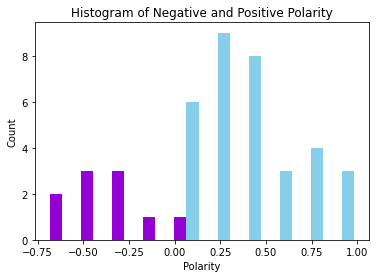

In [125]:
# Histogram showing Positive, Negative
neg_plot = list(neg_sentiment.select('polarity').toPandas()['polarity'])
pos_plot = list(pos_sentiment.select('polarity').toPandas()['polarity'])
neutral_plot = list(neutral_sentiment.select('polarity').toPandas()['polarity'])
plots = [neg_plot, pos_plot]
colors = ['darkviolet', 'skyblue']
plt.hist(plots,color = colors)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of Negative and Positive Polarity')
plt.show()

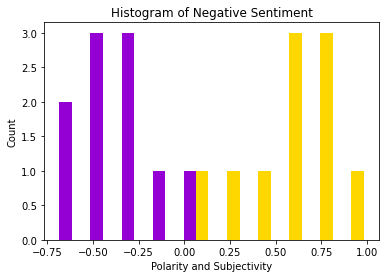

In [123]:
# Histogram of Negative Sentiment
neg_lst_pol = list(neg_sentiment.select('polarity').toPandas()['polarity'])
neg_lst_sub = list(neg_sentiment.select('subjectivity').toPandas()['subjectivity'])
plots = [neg_lst_pol, neg_lst_sub]
colors = ['darkviolet', 'gold']
plt.hist(plots, color = colors)
plt.xlabel('Polarity and Subjectivity')
plt.ylabel('Count')
plt.title('Histogram of Negative Sentiment')
plt.show()

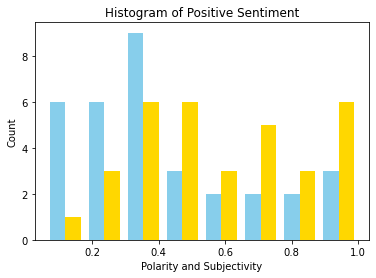

In [127]:
# Histogram showing Positive Sentiment
pos_lst_pol = list(pos_sentiment.select('polarity').toPandas()['polarity'])
pos_lst_sub = list(pos_sentiment.select('subjectivity').toPandas()['subjectivity'])
plots = [pos_lst_pol, pos_lst_sub]
colors = ['skyblue', 'gold']
plt.hist(plots, bins = 'auto', color = colors)
plt.xlabel('Polarity and Subjectivity')
plt.ylabel('Count')
plt.title('Histogram of Positive Sentiment')
plt.show()

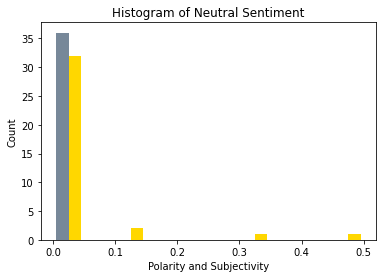

In [129]:
neut_lst_pol = list(neutral_sentiment.select('polarity').toPandas()['polarity'])
neut_lst_sub = list(neutral_sentiment.select('subjectivity').toPandas()['subjectivity'])
plots = [neut_lst_pol, neut_lst_sub]
colors = ['lightslategray', 'gold']
plt.hist(plots, color = colors)
plt.xlabel('Polarity and Subjectivity')
plt.ylabel('Count')
plt.title('Histogram of Neutral Sentiment')
plt.show()